INFO W18, Spring 2016 Section 1  
__Aaron Hogancamp, Maya Miller-Vedam, Svetlana Riva__  
__Final Project'Lab' Notebook__

# Contents
> __ I. Importing Modules__  
> __ II. Quick Look at Raw Data__  
> __ III. Importing and Cleaning Data__  
> __ IV. Analysis of NYPD 7 Major Felony Incidents__   
> __ V. NYC School Violence Dat Analysis__   
> __ VI. Lat Long Analysis (Combining Felony Data and School Violence Data)__  

## Required Files
_If you plan to run the code in this notebook please ensure that you have downloaded the following files (as provided in our Project submission zipped folder)_
> cleandata.py  
> NYPD_7_Major_Felony_Incidents.csv   
> New_York_City_Population_By_Boroughs.csv  
> 15-16SchoolDirectory.xlsx   
> VADIR_2006.xls, VADIR_2007.xls, VADIR_2008.xls, VADIR_2009.xls, VADIR_2010.xls, VADIR_2011.xls, VADIR_2012.xls, VADIR_2013.xls, VADIR_2014.xls

# I - Importing Modules

We will import the basics (matplotlib and pandas) and a few specialty modules (vincenty, geocoder and time) to be used within the analysis.  We also created our own custom module (cleandata) to be used for loading and cleaning the raw data.  We wanted to separate the loading and cleaning of the data in order to focus this notebook on the analysis portion.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
% matplotlib inline
%load_ext autoreload
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.ticker as tkr
from vincenty import vincenty
import geocoder as geo
import datetime as dt
import cleandata as cd
import time

----

# II - Getting Started - Quick look at the raw data

To get started, we will first describe the data. The majority of the analysis will be centered around felony incidents in <a href='https://catalog.data.gov/dataset/nypd-7-major-felony-incidents'>New York City</a> and the school violence incidents within <a href='http://www.p12.nysed.gov/irs/school_safety/school_safety_data_reporting.html'>NYC Schools</a>. For our analysis, we will also need NYC population data as well as <a href='https://data.dcpcsb.org/Schools-/2015-16-School-Directory/3d2c-rrhw'>school location data</a>.

__NYC Felony Data__ "Quarterly update of Seven Major Felonies at the incident level. For privacy reasons, incidents have been moved to the midpoint of the street segment on which they occur."

For our purposes, we will be using the general wikipedia definitions of the 7 types of felonies. Note that these definitions can sometimes change from state to state:
- Grand larceny: theft of personal property having a value above a legally specified amount.
- Robbery: the taking of another person's property by force, fear, or intimidation, with the intent to permanently deprive that person of the property.
- Burglary: typically defined as the unlawful entry into almost any structure (not just a home or business) with the intent to commit any crime inside (not just theft/larceny). No physical breaking and entering is required; the offender may simply trespass through an open door. Unlike robbery, which involves use of force or fear to obtain another person's property, there is usually no victim present during a burglary.
- Assault: carried out by a threat of bodily harm coupled with an apparent, present ability to cause the harm.
- Grand Larceny of Motor Vehicle: the unlawful taking of property — in this case, a vehicle — that belongs to someone else, done with the intent to permanently deprive the owner of the property.
- Rape: non-consensual sexual intercourse that is committed by physical force, threat of injury, or other duress
- Murder & Non-negligent Manslaughter: The unjustifiable, inexcusable, and intentional killing of a human being with (murder) or without (non-negligent) deliberation, premeditation, and malice.

__NYC School Violence Data__ "...reports detailing the number of incidents relating to School Safety and the Educational Climate (SSEC) reported to SED for the specified school years."

__NYC Population Data__ NYC Population by borough as reported in the 2010 Census.

__NYC School Location Data__ 2015 - 2016 NYC School directory of all NYC schools and their addresses. 

----

# III - Importing and Cleaning Data

Import and clean the felony data and school violence data.  NYC School Location data doesn't need cleaning.  NOTE: this uses our custom cleandata module provide as part of the submitted zip file.

__NYC Felony Data Cleanup__
* Resetting index and parsing dates
* Removing data prior to 2006 because this data has year and date issues
* Ensuring that Occurrence Year data is correct
* Creating columns for month ordering, day of week ordering and school year (in order to join correctly to the School Violence data.

__NYC School Violence Cleanup__ 
* The 2010 - 2014 files have the same column names, so they're easy to import and concatenate. However, 2006 - 2009 years each have a few unique column names, so they must be concatenated independently to the main dataframe. 
* Moreover, some columns have "w/ weapon" and others have "w/out weapon" in the column names. These were suffixed with "_ww" and "_nw" for 'with weapon' and 'no weapon', respectively. 
* Also re-ordered columns, merged duplicate columns, removed problematic (non data) rows from the csv, and fixed inconsistencies. 
* Ensured that all records have valid County data.

__NYC Population Data Cleanup__
* Capitalize Boroughs and set them as indexes.  This is done to match NYC Felony Data.
* Add areas (measured in sq miles, source: wikipedia)

In [2]:
#takes about 5 minutes to load and clean
school_df = cd.load_and_clean_VADIR()
felony_df = cd.load_and_clean_NYPD()
borough_df = cd.load_and_clean_BORPOP()
location_df = pd.read_excel("15-16SchoolDirectory.xlsx")

... data from VADIR_2006.xls appended. Added 1455 rows for a total of 1455.
... data from VADIR_2007.xls appended. Added 1500 rows for a total of 2955.
... data from VADIR_2008.xls appended. Added 1545 rows for a total of 4500.
... data from VADIR_2009.xls appended. Added 1531 rows for a total of 6031.
... data from VADIR_2010.xls appended. Added 1678 rows for a total of 7709.
... data from VADIR_2011.xls appended. Added 1693 rows for a total of 9402.
... data from VADIR_2012.xls appended. Added 1735 rows for a total of 11137.
... data from VADIR_2013.xls appended. Added 1792 rows for a total of 12929.
... data from VADIR_2014.xls appended. Added 1805 rows for a total of 14734.
... loaded NYPD felony data: 1116904 observations


----

# IV - Analysis of NYPD 7 Major Felony Incidents


In [3]:
# Overview
print("Number of observations:", len(felony_df), "\nNumber of Variables:", len(felony_df.columns),\
     "\nDate Range:", int(felony_df["Occurrence Year"].min()), "-", int(felony_df["Occurrence Year"].max()))

Number of observations: 1116904 
Number of Variables: 23 
Date Range: 2006 - 2015


In [4]:
# Take a look -- uncomment to run
#felony_df.head()

Percent of data dated 2000 or after: 99.42%


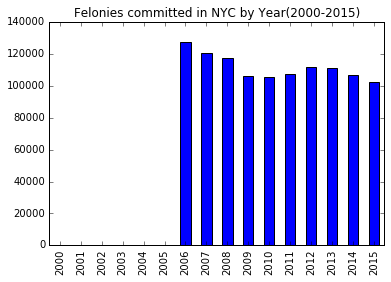

In [5]:
# what percent of the data is from 2006 and after?
year_counts = felony_df['Occurrence Year'].value_counts()
recent = year_counts[list(range(2006,2016))].sum()
print("Percent of data dated 2000 or after: {:.2f}%".format(recent/1123465 * 100))

# plot crime incidence by year (2000- 2015)
year_counts[list(range(2000,2016))].plot(kind = 'bar')
plt.title("Felonies committed in NYC by Year(2000-2015)")

In [6]:
# taking a look at totals by year
print("MEAN:",felony_df['Occurrence Year'].value_counts().mean())
felony_df['Occurrence Year'].value_counts()

MEAN: 111690.4


2006    127649
2007    120514
2008    117375
2012    111798
2013    111286
2011    107183
2014    106849
2009    106018
2010    105575
2015    102657
Name: Occurrence Year, dtype: int64

In [7]:
# 5 Boroughs Population
print("TOTAL POP:", borough_df['2010 Population'].sum())

TOTAL POP: 8175133


In [8]:
# Average Per Capita Felonies
felony_df['Occurrence Year'].value_counts().mean()/borough_df['2010 Population'].sum()

0.013662211978691967

In [9]:
# percent of felonies that are 'Grand Larceny'
felony_df.Offense.value_counts()['GRAND LARCENY'] /len(felony_df)

0.38017860084662602

#### Location and Type

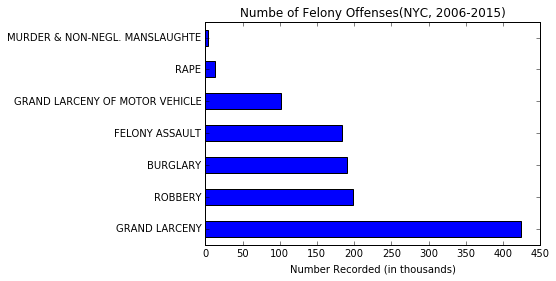

In [10]:
# plot crime incidence by felony type
felony_counts = felony_df.Offense.value_counts()/1000
#counts.sort_values(inplace=True)
felony_counts.plot(kind = 'barh')
plt.title("Numbe of Felony Offenses(NYC, 2006-2015)")
plt.xlabel("Number Recorded (in thousands)")

In [11]:
# Per Capita Felonies excluding Grand Larceny
felony_df[felony_df['Offense'] != 'GRAND LARCENY']['Borough'].value_counts()/borough_df['2010 Population']

(null)                NaN
BRONX            0.110133
BROOKLYN         0.094375
MANHATTAN        0.075893
QUEENS           0.072507
STATEN ISLAND    0.045184
dtype: float64

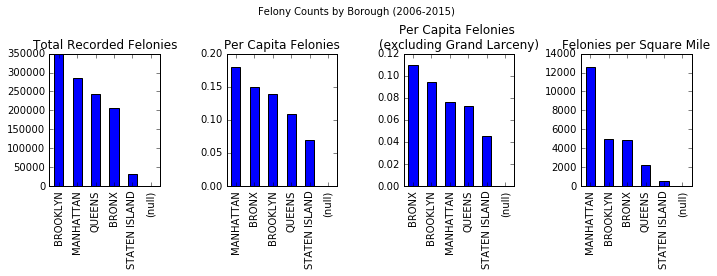

In [12]:
# Where do most felonies occur?
plt.subplots(1,3,figsize=(10,4))
plt.suptitle("Felony Counts by Borough (2006-2015)")

# plot crime incidence by borough 
plt.subplot(141)
felony_df.Borough.value_counts().plot(kind = 'bar')
plt.title("Total Recorded Felonies")

# plot crime incidence by borough 
plt.subplot(142)
per_capita = felony_df.Borough.value_counts() / borough_df['2010 Population']
per_capita.sort_values(ascending=False).plot(kind = 'bar')
plt.title("Per Capita Felonies")

# percapita crime excluding Grand Larceny
plt.subplot(143)
non_larceny = felony_df.Borough[felony_df.Offense != 'GRAND LARCENY'].value_counts() / borough_df['2010 Population']
non_larceny.sort_values(ascending=False).plot(kind = 'bar')
plt.title("Per Capita Felonies \n(excluding Grand Larceny)")

# plot crime incidence by sq mi
plt.subplot(144)
per_mi = felony_df.Borough.value_counts() / borough_df['Area(sq mi)']
per_mi.sort_values(ascending=False).plot(kind = 'bar')
plt.title("Felonies per Square Mile")

plt.tight_layout(h_pad=0.5, rect=[0, 0.03, 1, 0.95])

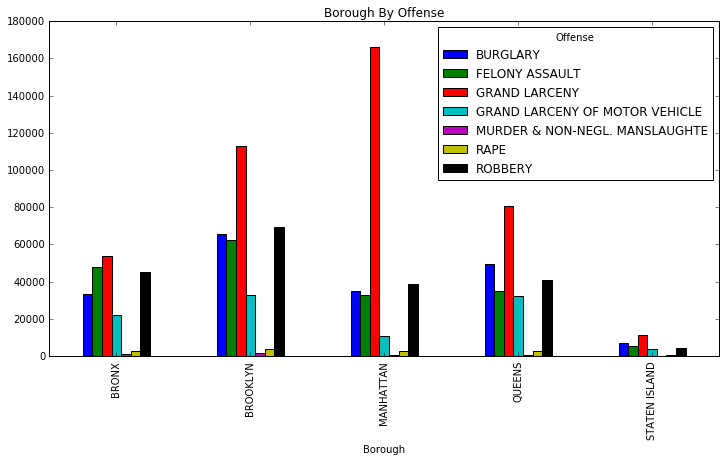

In [13]:
# create plot comparing types of Felonies by Borough
fel_by_bor = felony_df.groupby('Borough')['Offense'].value_counts()['BRONX':'STATEN ISLAND'].sort_values(ascending=False)
fel_by_bor_un = fel_by_bor.unstack("Offense")
fel_by_bor_un.sort_index(ascending=False, level = 'GRAND LARCENY')
fel_by_bor_un.plot(kind="bar", figsize= (12,6), title = "Borough By Offense")

#### Time series analysis

In [14]:
datecount = felony_df.groupby('Short Occurrence Date', as_index=False).Identifier.count()
yearcount = felony_df.groupby('Occurrence Year', as_index=False).Identifier.count()
monthcount = felony_df.groupby('Occurrence Month Ordered', as_index=False).Identifier.count()
daycount = felony_df.groupby('Occurrence Day', as_index=False).Identifier.count()
weekdaycount = felony_df.groupby('Day of Week Ordered', as_index=False).Identifier.count()
offensecount = felony_df.groupby('Offense', as_index=False).Identifier.count()
yearoffensecount = felony_df.groupby(['Occurrence Year', 'Offense'], as_index=False).Identifier.count()
yearoffensecountp = yearoffensecount.pivot('Occurrence Year', 'Offense', 'Identifier')

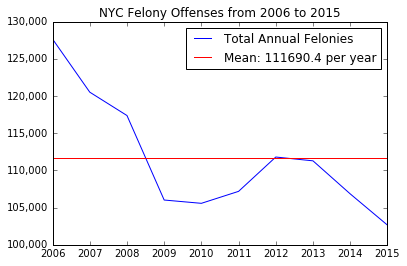

In [15]:
# felonies recorded from 2006 to 2015
x = yearcount['Occurrence Year']
xlabels = [int(xl) for xl in x]
y = yearcount["Identifier"]

# adding mean line for comparions
mean = len(felony_df)/len(felony_df['Occurrence Year'].unique())

def func(x, pos):  
   s = '{:0,d}'.format(int(x))
   return s

y_format = tkr.FuncFormatter(func) 
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.plot(x,y, label = 'Total Annual Felonies')
plt.plot(x,[mean]*10,'r', label='Mean: {} per year'.format(mean))
plt.title('NYC Felony Offenses from 2006 to 2015')
plt.legend()

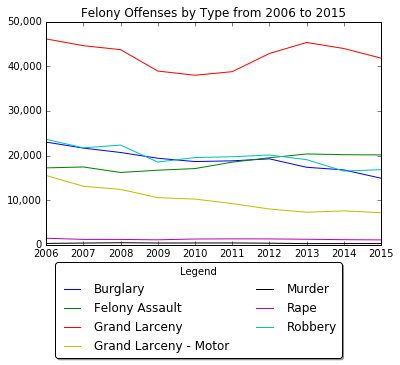

In [16]:
# wanted to see a breakout of the type of offenses across years

x = yearoffensecountp.index
xlabels = [int(xl) for xl in x]
yb = yearoffensecountp["BURGLARY"]
yfa = yearoffensecountp["FELONY ASSAULT"]
ygl = yearoffensecountp["GRAND LARCENY"]
yglmv = yearoffensecountp["GRAND LARCENY OF MOTOR VEHICLE"]
ymm = yearoffensecountp["MURDER & NON-NEGL. MANSLAUGHTE"]
yr = yearoffensecountp["RAPE"]
yrb = yearoffensecountp["ROBBERY"]

def func(x, pos):  
    s = '{:0,d}'.format(int(x))
    return s

y_format = tkr.FuncFormatter(func) 
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)

plt.plot(x, yb, 'b-', label='Burglary')
plt.plot(x, yfa, 'g-', label='Felony Assault')
plt.plot(x, ygl, 'r-', label='Grand Larceny')
plt.plot(x, yglmv, 'y-', label='Grand Larceny - Motor')
plt.plot(x, ymm, 'k-', label='Murder')
plt.plot(x, yr, 'm-', label='Rape')
plt.plot(x, yrb, 'c-', label='Robbery')

plt.legend(loc="best", bbox_to_anchor=[0.9, -0.05],
           ncol=2, shadow=True, title="Legend", fancybox=True)
plt.title('Felony Offenses by Type from 2006 to 2015')
plt.show()

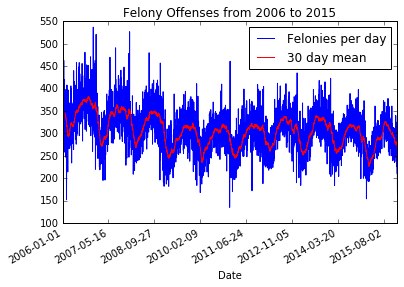

In [17]:
# get a time series view of the number of offenses per day
crimes_per_day = felony_df.groupby('Short Occurrence Date', as_index=True).Identifier.count()
crimes_per_day.plot(label='Felonies per day')
pd.rolling_mean(crimes_per_day, 30).plot(color='r', rot=30, label='30 day mean')
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2006 to 2015')
plt.xlabel('Date')
plt.legend()

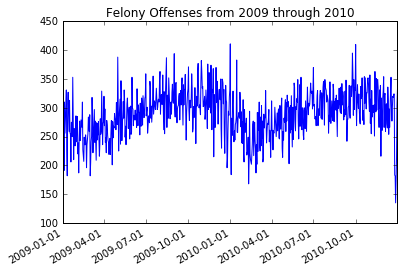

In [18]:
# there is an evident seasonal spike and valley in felonies each year
# the below shows a view for 2009 through 2010
datecount_2010 = datecount[datecount['Short Occurrence Date'] > '2008-12-31']
datecount_2010 = datecount_2010[datecount_2010['Short Occurrence Date'] < '2011-01-01']

dates = datecount_2010["Short Occurrence Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = datecount_2010["Identifier"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(x,y, label='Felonies per day')
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2009 through 2010')

#looks like the number of felonies spike in September/October and 
# then fall back down at the end of each calendar year

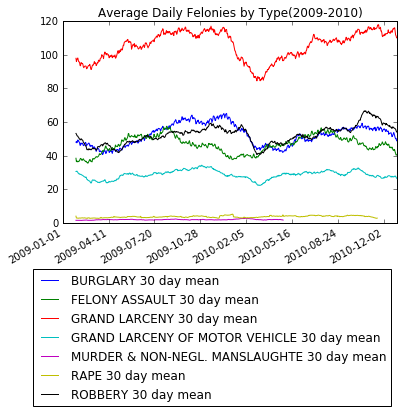

In [19]:
# Seasonal trends for each type
two_years = felony_df[(felony_df['Occurrence Year'] > 2008) & (felony_df['Occurrence Year'] < 2011)]
for name, df in two_years.groupby('Offense'):
    per_day = df.groupby('Short Occurrence Date', as_index=True).Identifier.count()
    pd.rolling_mean(per_day, 30).plot(rot=30, label= name +' 30 day mean')
    
plt.legend(loc="best", bbox_to_anchor=[1, -0.2], ncol=1)
plt.gcf().autofmt_xdate()
plt.title('Average Daily Felonies by Type(2009-2010)')


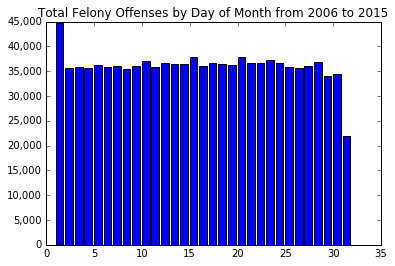

In [20]:
# there is a look of total felony offenses by day of month
# looks like the first of the month has the highest offenses - about 10,000 more than any other day
# perhaps this is just the busiest day to record offenses?
# 31 doesn't have as many offenses since not all months have 31 days - most likely
x = daycount['Occurrence Day']
y = daycount['Identifier']
plt.gca().yaxis.set_major_formatter(y_format)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Month from 2006 to 2015')

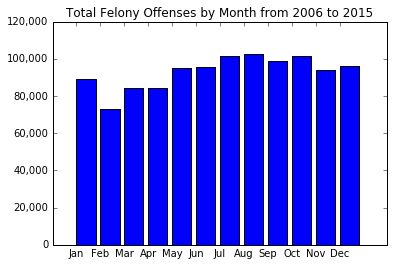

In [21]:
# breaking out the offenses by month total, it does look a bit seasonal and similar to the time series chart above
# February has the least number of offenses - potentially due to the cold weather in nyc
# need to determine how to center the month x axis tick labels
x = range(len(monthcount['Occurrence Month Ordered']))
xlabels = [x[-4:-1] for x in monthcount['Occurrence Month Ordered']]
y = monthcount['Identifier']
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-1,len(xlabels)+1)
locs = np.arange(len(xlabels))
plt.bar(x,y)
plt.title('Total Felony Offenses by Month from 2006 to 2015')
plt.show()

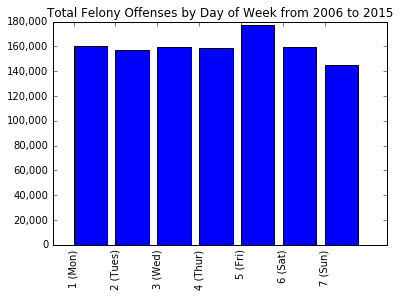

In [22]:
# breaking out offenses by day of week, Friday spikes with almost 20,000 more offenses than any other day
x = range(len(weekdaycount['Day of Week Ordered']))
xlabels = [x for x in weekdaycount['Day of Week Ordered']]
y = weekdaycount['Identifier']
plt.xticks(x, xlabels, rotation='vertical')
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-0.5,len(xlabels)+0.5)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Week from 2006 to 2015')
plt.show()

In [23]:
# Examining weekday trends
felony_df['Day of Week Ordered'].value_counts()/len(felony_df)

5 (Fri)     0.158704
1 (Mon)     0.143517
6 (Sat)     0.142633
3 (Wed)     0.142549
4 (Thur)    0.141791
2 (Tues)    0.140647
7 (Sun)     0.130159
Name: Day of Week Ordered, dtype: float64

-----

# V - NYC School Violence Data Analysis

In [24]:
#Overview
print("Number of observations:", len(school_df), "\nNumber of Variables:", len(school_df.columns),\
     "\nDate Range:", int(felony_df["School Year"].min()), "-", int(felony_df["School Year"].max()))

Number of observations: 14730 
Number of Variables: 45 
Date Range: 2005 - 2015


In [25]:
# Take a look -- uncomment to run
#school_df.head()

In [26]:
# Setting Up Tally Columns
WEAPON_INCIDENT_COLS = ['Assault With Serious Physical Injury_ww',
                        'Assault with Physical Injury_ww', 'Bomb Threat', 'Burglary_ww',
                        'Criminal Mischief_ww', 'Forcible Sex Offenses_ww',
                        'Homicide_ww','Intimidation, Harassment, Menacing, or Bullying_ww', 
                        'Kidnapping_ww', 'Larceny, or Other Theft_ww', 'Minor Altercations_ww', 'Other Sex Offenses_ww',
                        'Reckless Endangerment_ww', 'Riot_ww', 'Robbery_ww', 
                        'Weapon Possession_oc', 'Weapon Possession_ts']

NON_WEAPON_INCIDENT_COLS = ['Alcohol Possession', 'Arson', 
                            'Assault With Serious Physical Injury_nw',
                            'Assault with Physical Injury_nw', 'Bomb Threat False Alarm', 
                            'Burglary_nw', 'Criminal Mischief_nw', 'Drug Possession',
                            'Forcible Sex Offenses_nw', 'Forcible Sex Offenses_ww', 
                            'Homicide_nw', 'Intimidation, Harassment, Menacing, or Bullying_nw',
                            'Kidnapping_nw', 'Larceny, or Other Theft_nw', 
                            'Minor Altercations_nw','Other Disruptive Incidents', 
                            'Other Sex Offenses_nw', 'Reckless Endangerment_nw', 'Riot_nw',
                            'Robbery_nw']

ALL_INCIDENT_COLS = WEAPON_INCIDENT_COLS + NON_WEAPON_INCIDENT_COLS
for col in ALL_INCIDENT_COLS:
    school_df[col] = school_df[col].astype(np.float64)

# Tallying Incidents with and without weapons
school_df['Total Incidents'] = school_df[ALL_INCIDENT_COLS].sum(axis=1)
school_df['Incidents w/ Weapons'] = school_df[WEAPON_INCIDENT_COLS].sum(axis=1)
school_df['Incidents w/o Weapons'] = school_df[NON_WEAPON_INCIDENT_COLS].sum(axis=1)

In [27]:
# average number of incidents
av_tot = school_df.groupby('School Year')['Total Incidents'].sum().mean()
print("AVERAGE ANNUAL TOTAL:", av_tot )
av_ww = school_df.groupby('School Year')['Incidents w/ Weapons'].sum().mean()
print("AVERAGE WW TOTAL:", av_ww )
per_student = school_df.groupby('School Year')['Total Incidents'].sum()
per_student /= school_df.groupby('School Year')['Enrollment'].sum()
print("PER STUDENT:", per_student.mean() )

AVERAGE ANNUAL TOTAL: 61149.88888888889
AVERAGE WW TOTAL: 5489.444444444444
PER STUDENT: 0.05966135440702177


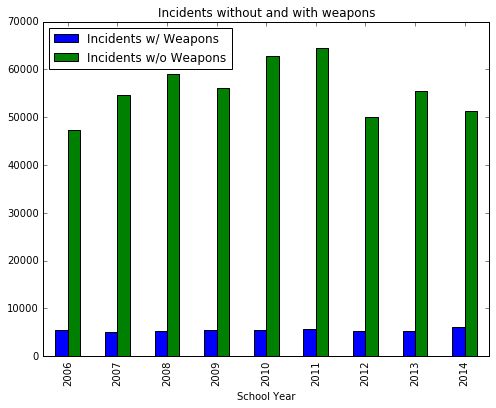

In [28]:
# Plotting incidents with and without weapons.
school_df["School Year"] = school_df["School Year"].astype(int)
inc_cols = ['Incidents w/ Weapons','Incidents w/o Weapons']
#school_df[inc_cols].head()
#secondary_y = inc_cols[1]
fig = school_df.groupby("School Year")[inc_cols].sum().plot(kind="bar", figsize = (8, 6), 
                                                      legend=True,
                                                      title = "Incidents without and with weapons"
                                                      )

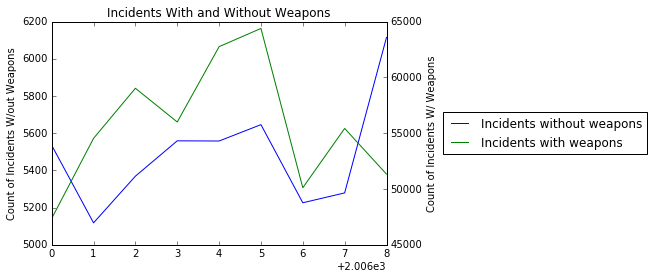

In [29]:
# Another look at similar values
fig, ax = plt.subplots()

ax.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[0]].sum(),
        'b',
       label = "Incidents without weapons")
ax.set_ylabel("Count of Incidents W/out Weapons")

ax2 = ax.twinx()
ax2.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[1]].sum(),
         'g',
       label = "Incidents with weapons")
ax2.set_ylabel("Count of Incidents W/ Weapons")

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc = "center left", bbox_to_anchor = (1.15, 0.5))
ax.set_title("Incidents With and Without Weapons")
plt.show()

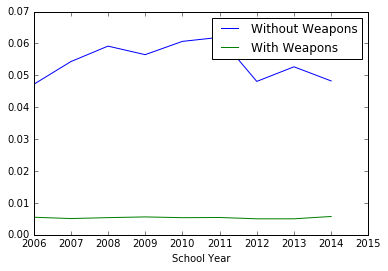

In [30]:
# Per Pupil Incidents
school_df['Enrollment'] = school_df.Enrollment.astype(np.float64)
by_year = school_df.groupby("School Year").sum()
(by_year['Incidents w/o Weapons']/ by_year['Enrollment']).plot(label='Without Weapons')
(by_year['Incidents w/ Weapons']/ by_year['Enrollment']).plot(label='With Weapons')

# Plot formatting
xvals = list(range(2006,2016))
plt.xticks(xvals,[str(x) for x in xvals])
plt.xlabel('School Year')
plt.legend()

In [31]:
# Creating some general categories of school incidents
Assault = ['Assault With Serious Physical Injury_ww','Assault with Physical Injury_ww',
           'Assault With Serious Physical Injury_nw','Assault with Physical Injury_nw' ]
school_df['Assault'] = school_df[Assault].apply(sum, axis=1)

BombThreatRiotArson = ['Bomb Threat','Riot_ww','Arson','Bomb Threat False Alarm','Riot_nw']
school_df['Bomb Threat, Riot, Arson'] = school_df[BombThreatRiotArson].apply(sum, axis=1)

SexOffensesKidnppingHomicide = ['Forcible Sex Offenses_ww','Homicide_ww','Kidnapping_ww',
                                'Other Sex Offenses_ww','Forcible Sex Offenses_nw',
                                'Forcible Sex Offenses_ww','Homicide_nw','Kidnapping_nw',
                                'Other Sex Offenses_nw', ]
school_df['Sex Offenses, Kidnpping, Homicide'] = school_df[SexOffensesKidnppingHomicide].apply(sum, axis=1)

BurglaryRobberyTheft= ['Burglary_ww','Larceny, or Other Theft_ww', 'Robbery_ww','Burglary_nw',
                       'Larceny, or Other Theft_nw','Robbery_nw']
school_df['Burglary, Robbery, Theft'] = school_df[BurglaryRobberyTheft].apply(sum, axis=1)

CriminalMischiefRecklessEndangerment = ['Criminal Mischief_ww','Reckless Endangerment_ww',
                                        'Criminal Mischief_nw','Reckless Endangerment_nw']
school_df['Criminal Mischief, Reckless Endangerment'] = school_df[CriminalMischiefRecklessEndangerment].apply(sum, axis=1)

MinorAltercations = ['Minor Altercations_ww','Minor Altercations_nw']
school_df['Minor Altercations']= school_df[MinorAltercations].apply(sum, axis=1)

Bullying = ['Intimidation, Harassment, Menacing, or Bullying_ww',
            'Intimidation, Harassment, Menacing, or Bullying_nw']
school_df['Bullying'] = school_df[Bullying].apply(sum, axis=1)

AlcoholDrug = ['Alcohol Possession', 'Drug Possession']
school_df['Alcohol or Drug Possession'] = school_df[AlcoholDrug].apply(sum, axis=1)

WeaponPossession = ['Weapon Possession_oc', 'Weapon Possession_ts']
school_df['Weapon Possession'] = school_df[WeaponPossession].apply(sum, axis=1)

INCIDENT_CATEGORIES = ['Assault','Bomb Threat, Riot, Arson','Sex Offenses, Kidnpping, Homicide',
                       'Burglary, Robbery, Theft', 'Criminal Mischief, Reckless Endangerment',
                       'Bullying','Alcohol or Drug Possession', 'Weapon Possession',
                       'Minor Altercations']

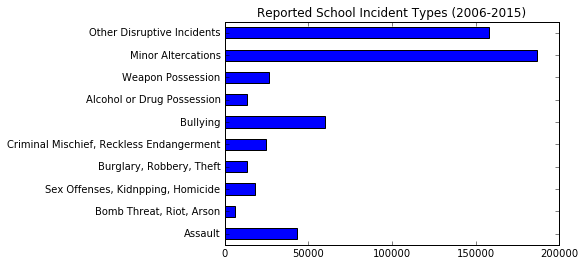

In [32]:
# Different kinds of school offenses by year
cols_to_plot = INCIDENT_CATEGORIES + ['Other Disruptive Incidents']
school_df[cols_to_plot].sum().plot(kind='barh', title="Reported School Incident Types (2006-2015)")

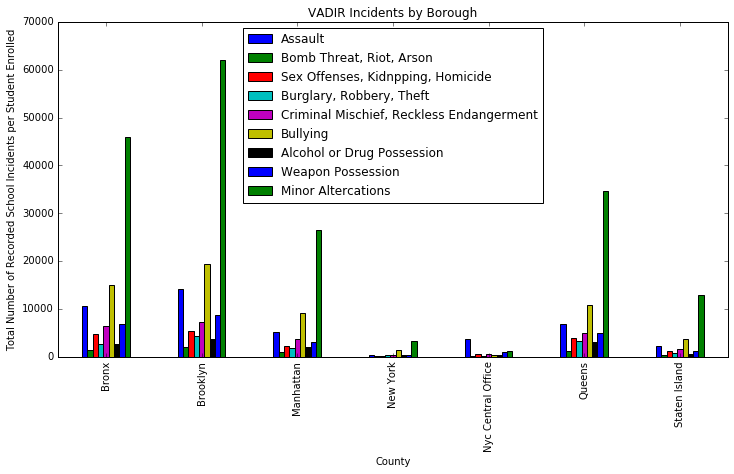

In [98]:
# VADIR incidents by borough - Non Normed
inc_by_bor = school_df.groupby('County')[INCIDENT_CATEGORIES].sum()
inc_by_bor.plot(kind='bar',figsize= (12,6), title = "VADIR Incidents by Borough")
plt.ylabel('Total Number of Recorded School Incidents per Student Enrolled')

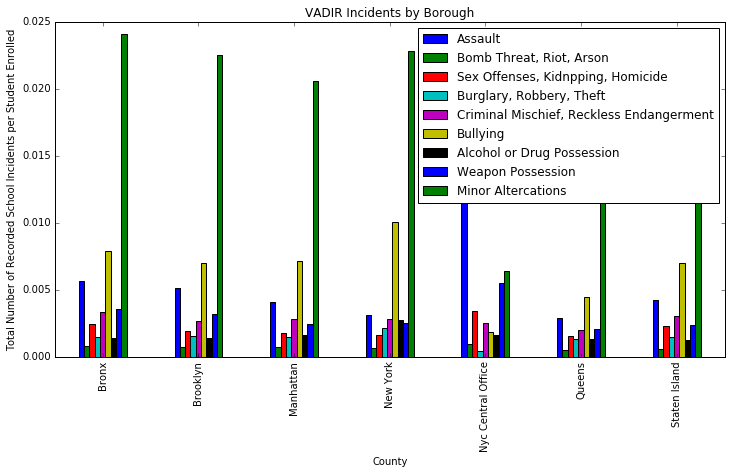

In [97]:
# VADIR Incidents by Borough - Normed
inc_by_bor = school_df.groupby('County')[INCIDENT_CATEGORIES + ['Enrollment']].sum()
inc_by_bor = inc_by_bor.apply(lambda x: x/x.Enrollment, axis=1)
inc_by_bor[INCIDENT_CATEGORIES].plot(kind='bar',figsize= (12,6), title = "VADIR Incidents by Borough")
plt.ylabel('Total Number of Recorded School Incidents per Student Enrolled')

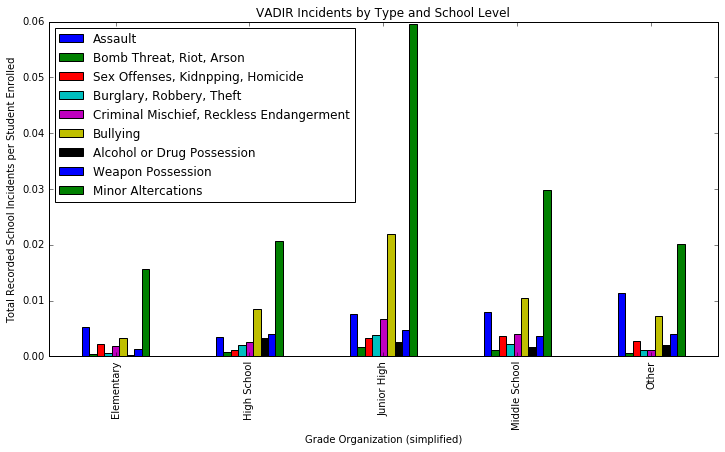

In [116]:
# fix grade organization duplication
SCHOOL_ORG_DICT = {'Elementary':'Elementary', 'Senior High':'High School', 'Middle':'Middle School',
                   'Junior-Senior High': 'High School', 'Junior Senior School': 'High School',
                   'Junior High School': 'Junior High', 'K-12':'Other', 
                   'Not Available':'Other', 'Special': 'Other', 'Special School':'Other'}
# create new column for simplified school level
school_df['Grade Organization (simplified)'] = school_df['Grade Organization'].map(SCHOOL_ORG_DICT)

# create plot comparing types of Incidents by Borough
inc_by_schoolorg = school_df.groupby('Grade Organization (simplified)')
inc_by_schoolorg = inc_by_schoolorg[INCIDENT_CATEGORIES + ['Enrollment']].sum()
inc_by_schoolorg = inc_by_schoolorg.apply(lambda x: x/x.Enrollment, axis=1)
inc_by_schoolorg[INCIDENT_CATEGORIES].plot(kind='bar',figsize= (12,6), title = "VADIR Incidents by Type and School Level")
plt.ylabel('Total Recorded School Incidents per Student Enrolled')


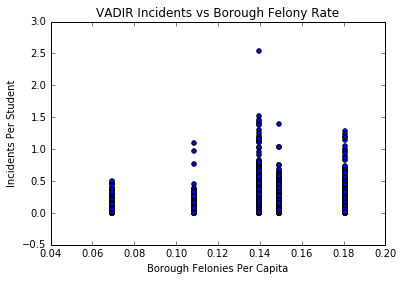

In [117]:
# VADIR incidents per student vs per capita felonies by borough.
# ... I think this is the wrong kind of plot for this sort of thing....
per_capita = (felony_df.Borough.value_counts() / borough_df['2010 Population']).to_dict()
per_capita = {k.title():per_capita[k] for k in per_capita.keys()}
school_df['Borough Felonies Per Capita'] = school_df.County.map(per_capita)
school_df['Incidents Per Student']= school_df.apply(lambda x: x['Total Incidents']/x.Enrollment, axis=1)
school_df.plot(x='Borough Felonies Per Capita', y='Incidents Per Student', kind='scatter')
plt.title('VADIR Incidents vs Borough Felony Rate')


----

# VI -  Lat Long Analysis (Combining Felony Data and School Violence by location).

This portion of our project uses the schools' latitude and longitude (obtained using geocoder) to perform some final cleaning on the VADIR data and then join it to the NYC crime data by location. The code below will:  

* (A): __Identify Schools' GPS Location__ using Geocoder and addresses in NYC School Directory file).
* (B): __Join latlong data__ to the school data frame (using beds/sed code).
* (C): __Replace inconsistent school names__ (with the legal names from the lat long file)  
* (D): __Identify felonies within a 1 mile__ radius of a given school.  
* (E): __Plot correlations__ between school indicents and felonies (by year, by borough, by felony type, by location, by school incident type).

### VII.A - Create Lat/Lon values using Geocoder based on school addresses from NYC School Directory data

In [33]:
# Finds which schools exist in both the violence and location dataframes
loc_sed = set(location_df["SED CODE"].astype(np.int64))
sch_beds = set(school_df["BEDS Code"].astype(np.int64))
print("Location file school count:", len(loc_sed), "\nSchool violence school count:", len(sch_beds),
      "\nSchools with both violence and locations:", len(loc_sed & sch_beds))
school_beds_with_addresses = [x for x in sch_beds if x in (loc_sed & sch_beds)]
filtered_school_df = school_df[school_df["BEDS Code"].isin(school_beds_with_addresses)]
filtered_school_df.reset_index(inplace = True, drop = True)

Location file school count: 7200 
School violence school count: 1967 
Schools with both violence and locations: 1807


In [34]:
#Created a beds_df that will also house the lat lon info
location_df["Full_Address"] = location_df["MAILING ADDRESS"] + ", " + location_df["CITY"] + \
                                ", " + location_df["STATE"] + ", " + location_df["ZIP"]

beds_df = location_df[location_df['SED CODE'].isin(school_beds_with_addresses)][['SED CODE', 'LEGAL NAME', 'Full_Address']]

## WARNING: The next cell can only be run once a day.

It takes at least 10 minutes to run as well. This is a limitation of Google - only 2500 calls can be made per day and the cell below calls it 1,807 times.

In [35]:
# Takes 10 min at least for all 1,807 schools! Only works ONCE A DAY due to geocoder 
# restrictions with Google (2,500 calls per day)

latlon = [geo.google(x).latlng for x in beds_df.Full_Address]
beds_df["latlon"] = latlon
beds_df.head()


,SED CODE,LEGAL NAME,Full_Address,latlon
2140,300000010777,BUREAU FOR HUNTER COLL CAMPUS SCHOOL,"71 E 94TH ST, NEW YORK, NY, 10128","[40.7858238, -73.9538841]"
2142,307500011035,PS 35,"317 W 52ND ST, NEW YORK, NY, 10019","[40.7640485, -73.985947]"
2143,307500011079,PS 79 HORAN SCHOOL,"55 E 120TH ST, NEW YORK, NY, 10035","[40.80250880000001, -73.94237050000001]"
2144,307500011094,PS 94,"55 BATTERY PL, NEW YORK, NY, 10001","[40.70656290000001, -74.0175278]"
2145,307500011138,PS 138,"144-176 E 128TH ST, NEW YORK, NY, 10035","[40.8057191, -73.9353352]"


## END WARNING

In [36]:
# Add "Lat" and "Lon" columns on the filtered school dataframe

latlon_list = beds_df.latlon.tolist()
beds_df["Lat"] = [x[0] if x!=[] else [] for x in latlon_list]
beds_df["Lon"] = [x[1] if x!=[] else [] for x in latlon_list]
beds_df[["Full_Address", "Lat", "Lon"]].head()

,Full_Address,Lat,Lon
2140,"71 E 94TH ST, NEW YORK, NY, 10128",40.7858,-73.9539
2142,"317 W 52ND ST, NEW YORK, NY, 10019",40.764,-73.9859
2143,"55 E 120TH ST, NEW YORK, NY, 10035",40.8025,-73.9424
2144,"55 BATTERY PL, NEW YORK, NY, 10001",40.7066,-74.0175
2145,"144-176 E 128TH ST, NEW YORK, NY, 10035",40.8057,-73.9353


In [37]:
#save this off to csv since we can only run once per 24 hour period
beds_df.to_csv("SchoolLatLon.csv")

### VI.B - Join School Data and Location Data

In [38]:
#import previously exported lat/lon data
latlon_df = pd.read_csv('SchoolLatLon.csv', index_col=0)

In [39]:
# Helper function -- extract lat/long from object type
def parse_latlong(dataframe, loc_column):
    """
    Function to extract lat/long coords. 
    INPUT: dataframe and name of column with string tuple or list pair of coordinates.
    OUTPUT: n/a. Function modifies dataframe to add a lat and long column with float type.
    """
    get_lat = lambda x: x.split(',')[0][1:] if type(x)==type('s') else np.nan
    get_long = lambda x: x.split(',')[1][:-1] if type(x)==type('s') else np.nan
    dataframe['lat'] = dataframe[loc_column].apply(get_lat).astype('float64')
    dataframe['long'] = dataframe[loc_column].apply(get_long).astype('float64')
    print('... latitude and longitude extracted for dataframe.') 

In [45]:
# Helper function to add latitude and longitudes to school data frame
def join_latlong(school_df, latlon_df, talk=False):
    """
    Function to add (and parse)latitude and longitude 
    information for each school.
    INPUT: school dataframe including "BEDS Code" column,
           latitude/longitude dataframe w/ "SED CODE" col.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: dataframe with school data plut new columns 
            for 'LEGAL NAME', 'Full_Address', 'latlon'(obj),
            lat(float64) and long(float64).
    """
    # ensure BEDS and SED are integers so that they'll be recognized as identical
    latlon_df["SED CODE"] = latlon_df["SED CODE"].astype(np.int64)
    school_df["BEDS Code"] = school_df["BEDS Code"].astype(np.int64)
    
    # join latlong data to school data using the BEDS code
    school_df = pd.merge(school_df, latlon_df, left_on=['BEDS Code'],right_on=['SED CODE'], how='left')
    
    # drop the now redundant SED code
    school_df.drop(['SED CODE'], axis=1, inplace=True)
    
    # Take a look at the resulting data/missing values
    if talk:
        print('... joined df inclues {} unique schools,'.format(len(school_df['BEDS Code'].unique())))
        schools_withloc = school_df[school_df['latlon'].notnull()]['BEDS Code'].unique()
        schools_missingloc = school_df[school_df['latlon'].isnull()]['BEDS Code'].unique()
        print('... of which {} have lat/long'.format(len(schools_withloc)),
              'and {} are missing lat/long'.format(len(schools_missingloc)))
        
    return school_df

In [47]:
# Function Call
school_df = join_latlong(school_df, latlon_df, talk=True)

In [50]:
# Replace empty lat/long
school_df.latlon.replace('[]', np.nan, inplace=True)

In [51]:
# parse latlon object in to numerical columns
parse_latlong(school_df, 'latlon')    

... latitude and longitude extracted for dataframe.


In [52]:
# Take a look -- uncomment to run
#school_df.head(10)

### VI.C - Fix School Names using info from 'latlon' file.

In [53]:
#function to eliminate duplicated school names using newly appended columns
def fix_school_names(school_df, talk=False):
    """ 
    INPUT: school_df with original 'School Name' column
           and with 'LEGAL NAME' column from latlong file.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to replace duplicate
           'School Name's with their (consistent) legal name.
    """
    if talk:
        print('... original dataset had {} unique'.format(len(school_df['School Name'].unique())),
              'school names but only {} unique BEDS Codes'.format(len(school_df['BEDS Code'].unique())))
    
    # Fix missing LEGAL NAMES with School Name
    school_df['LEGAL NAME'].fillna(school_df['School Name'], inplace=True)
    # Fix case and reassign to School Name
    school_df['School Name'] = school_df['LEGAL NAME'].apply(cd.fix_case)
    # drop the now redundant LEGAL NAME column
    school_df.drop(['LEGAL NAME'], axis=1, inplace=True)
    
    if talk:
        print('... new dataset has {} unique school '.format(len(school_df['School Name'].unique())),
              'names and {} unique BEDS Codes.'.format(len(school_df['BEDS Code'].unique())))

In [54]:
# function call
fix_school_names(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... original dataset had 3135 unique school names but only 1967 unique BEDS Codes
... new dataset has 1959 unique school  names and 1967 unique BEDS Codes.


### VI.D - Extracting crime tallies w/in radius of schools

The functions below build together to ultimately 'join' our two datasets by adding columns to the school dataset for tallies of each type of felony that occurred w/in a 1 mile radius. 

#### Part 1: Distance Calculation using Vincenty

In [55]:
# Helper function -- check dist
def is_in_radius(school_point, crime_point, radius):
    """
    Function using vincenty package to check distance between school and crime.
    INPUT: (lat,long) tuples for school and crime (in degrees), radius in miles.
    OUTPUT: Boolean
    """
    return vincenty(school_point, crime_point, miles=True) <= radius

In [56]:
#ensure that lat and long columns are added to the felony_df as well
#and reset index
parse_latlong(felony_df, 'Location 1')
felony_df = felony_df.reset_index()

... latitude and longitude extracted for dataframe.


In [57]:
# Testing vincenty on the first felony and first school
first_school_point = (school_df.loc[0,'lat'], school_df.loc[0,'long']) 
first_felony_point = (felony_df.loc[1,'lat'], felony_df.loc[1,'long']) 

# not w/in 2 miles, but yes, w/in 50
print('Distance: ', vincenty(first_school_point, first_felony_point))
print("... w/in 2 mi?", is_in_radius(first_school_point, first_felony_point, 2))
print("... w/in 50 mi?",is_in_radius(first_school_point, first_felony_point, 50))

Distance:  24.058529
... w/in 2 mi? False
... w/in 50 mi? True


#### Part 2: Setting up a grid for NYC lat/long coords

The goal is to use a grid strategy to avoid searching the entire NYC Felony dataframe for each school location (which would take too long). NOTE: _The max lat of a school is ~ 40.9  and the distance between 40.9 and 40.95 is over 3 miles... but there are 7 crimes that fell under the jurisdiction of the NY Transit police whose locations are recorded north of 41 degrees (the farthest one is 500 miles away ?!). The minimum longitude of a school is ~-74.24 which is around 3 miles from -74.3. There are 63 crimes that occurred west of -74.3. We will disregard these values for now since they are not in proximity to any of our schools._

In [58]:
# Initial exploration of ranges
max_lat = school_df.lat.max()
min_lat = school_df.lat.min()
max_long = school_df.long.max()
min_long = school_df.long.min()

lat_dist = vincenty((min_lat, 0.5*(max_long + min_long)),(max_lat, 0.5*(max_long + min_long)), miles=True)
long_dist = vincenty((min_long, 0.5*(max_lat + min_lat)),(max_long, 0.5*(max_lat + min_lat)), miles=True)

print('Latitude ranges from {} to {} with a total distance of {}'.format(min_lat, max_lat, lat_dist))
print('Longitude ranges from {} to {} with a total distance of {}'.format(min_long, max_long, long_dist))

Latitude ranges from 40.5078027 to 40.9034547 with a total distance of 27.300837
Longitude ranges from -74.2440251 to -73.4883134 with a total distance of 52.408039


In [59]:
# Helper function to identify grid cell that contains a given point
def nyc_grid(lat,long):
    """
    This function identifies a square mile cell of NYC that contains 
    the given longitude and latitude point. There are 1500 cells in 
    total. 30 rows each represent a segement of latitude and 50 
    columns each represent a segment of longitude. The cells are 
    numbered 0 through 1499 and they are unique to this analysis.
    """
    # max and min values from data set
    max_lat = 40.95
    min_lat = 40.50
    max_long = -73.45
    min_long = -74.30
    
    # divide each range into segments of a little over a mile
    delta_lat = (max_lat - min_lat)/28
    delta_long = (max_long - min_long)/48

    # then segment each direction
    lat_seg = np.array([min_lat + idx*delta_lat for idx in range(-1,29)])
    long_seg = np.array([min_long + idx*delta_long for idx in range(-1,49)])

    # identify where given point fits in segments
    row = sum(lat_seg <= lat) - 1
    col = sum(long_seg <= long) - 1
    
    # return grid number
    if row < 0 or row == 29 or col < 0 or col == 49:
        return np.nan
    else:
        return row * 50 + col

In [60]:
# Test an out of bound point
nyc_grid(40.653161, -76.862164)

nan

In [61]:
# Test an in bound point
nyc_grid(40.821798, -73.886463)

1074

In [62]:
#add NYC_grid column to felony_df
#WARNING - takes about 4 minutes to run
felony_df['NYC_grid'] = felony_df.lat.combine(felony_df.long, func=nyc_grid)

In [63]:
#add NYC_grid column to school_df
school_df['NYC_grid'] = school_df.lat.combine(school_df.long, func=nyc_grid)

#### Part 3: Function to find crimes w/in 1 mile of a school

STRATEGY: Identify the grid cell containing the school and then search only that cell and its immediately adjacent cells.

In [64]:
# helper function to get a list of adjacent cells
def get_adjacent(cell_num):
    """ 
    This function identifies a group of cells which together superset 
    any points within a mile of any location in the original cell.
    INPUT: a cell number (< 1500) from NYC grid
    OUTPUT: a list of adjacent and or diagonal cell numbers
    
    NOTE: this function should only be run on cell numbers of vadir
    school locations since the nyc_grid is designed so that all
    schools are in a cell that is not a boarder cell.
    """
    col = cell_num % 50
    row = cell_num // 50
    row_range = [row - 1, row, row + 1]
    col_range = [col - 1, col, col + 1]
    return [r * 50 + c for r in row_range for c in col_range]
    

In [65]:
# Test grid adjacency
get_adjacent(52)

[1, 2, 3, 51, 52, 53, 101, 102, 103]

In [66]:
# helper function to get subset of felonies within a 1 mile radius
def get_local_crimes(location, felony_df):
    """
    This function identifies crimes less than 1 mi 
    from a single school (or GPS location).
    INPUT: location (GPS point), felony_df (w/ 'NYC_grid column already populated)
    OUTPUT: felony_df subset of crimes that occurred within one mile of school.   
    """
    cells_to_search = get_adjacent(nyc_grid(*location))
    
    # Get subset of crimes w/in grid
    cells_to_search = get_adjacent(nyc_grid(*location)) 
    crimes = felony_df.loc[felony_df.NYC_grid.isin(cells_to_search)]
    
    # Further subset by a radius of 1 mile
    if not crimes.empty: 
        r_filter = lambda x: is_in_radius(location,(x.lat,x.long),1)
        crimes =  crimes[crimes.apply(r_filter, axis=1)]
        
    return crimes

In [67]:
# test function on a single school / no crimes
this_school = school_df[school_df['BEDS Code'] == 307500014256]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

In [ ]:
# now testing on a school with crimes
this_school = school_df[school_df['BEDS Code'] == 307500012017]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

In [ ]:
# Take a look - uncomment to run
#result.head()

#### Part 4: Crime counting function to search only within adjacent cells of the school

NOTE: loading grid cell#s for the felony data set takes 3-4 minutes and only needs to be done once. To skip that step after you've already run this function before simply set the optional parameter skip_gridsetup to True (it defaults False)

In [68]:
def tally_crime_by_loc(school_df, felony_df, skip_gridsetup = False):
    """
    Function to tally and store information about felonies 
    that occur w/in one mile of each school in the school_df.
    INPUT: school df w/ cols 'latlon', 'lat', 'long', and 'School Year'
           felony df w/ cols 'Occurrence Year', 'lat','long','Offense', and 'Identifier'
    OUTPUT: n/a, modifies school data.
    """
    if not skip_gridsetup:
        # prepare felony dataframe by adding a column for nyc_grid cell number
        felony_df.lat.fillna(0, inplace=True)
        felony_df.long.fillna(0, inplace=True)
        felony_df['NYC_grid'] = felony_df.apply(lambda x: nyc_grid(x.lat, x.long),axis=1)

    # Initialize new columns in school data frame
    school_df['CrimeIDS'] = pd.Series()
    school_df['Total Felonies w/in 1mi'] = pd.Series()
    school_df['Grand Larceny w/in 1mi'] = pd.Series()
    school_df['Robbery w/in 1mi'] = pd.Series()
    school_df['Burglary w/in 1mi'] = pd.Series()
    school_df['Assault w/in 1mi'] = pd.Series()
    school_df['Auto Theft w/in 1mi'] = pd.Series()
    school_df['Rape w/in 1mi'] = pd.Series()
    school_df['Murders w/in 1mi'] = pd.Series()
    
    # Group schools (unique location for each BEDS Code) 
    grouped = school_df[school_df.lat.notnull()].groupby(['BEDS Code'])
    
    # Loop through schools, subset crime by location. 
    for beds, df in grouped:
        # NOTE: the coordinates should all be the same so the mean is just the location
        assert len(df.lat.unique().tolist()) == 1, 'ERROR: multiple latitudes for this school.'
        location = (df.lat.mean(), df.long.mean())
        local_crimes = get_local_crimes(location, felony_df)

        # tally and store felonies for each year
        for year in df['School Year'].unique():
            subset = local_crimes[local_crimes['School Year'] == year]
            idxs = df[df['School Year'] == year].index.tolist()
            school_df.loc[idxs,['CrimeIDS']] = str(subset.Identifier.unique().tolist())
            school_df.loc[idxs,['Total Felonies w/in 1mi']] = len(subset)        
            school_df.loc[idxs,['Grand Larceny w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY')
            school_df.loc[idxs,['Robbery w/in 1mi']] = sum(subset['Offense'] == 'ROBBERY')
            school_df.loc[idxs,['Burglary w/in 1mi']] = sum(subset['Offense'] == 'BURGLARY')
            school_df.loc[idxs,['Assault w/in 1mi']] = sum(subset['Offense'] == 'FELONY ASSAULT')
            school_df.loc[idxs,['Auto Theft w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY OF MOTOR VEHICLE')
            school_df.loc[idxs,['Rape w/in 1mi']] = sum(subset['Offense'] == 'RAPE')
            school_df.loc[idxs,['Murders w/in 1mi']] = sum(subset['Offense'] == 'MURDER & NON-NEGL. MANSLAUGHTE')

    print('... tallied felonies w/in 1 mile of each school.')

## WARNING: The next cell takes ~2hrs to run
For a faster option try importing previously saved results (vadir_with_felonycounts.csv)

In [69]:
# tally crimes and add counts to school_df dataframe
tally_crime_by_loc(school_df, felony_df, skip_gridsetup=True)

... tallied felonies w/in 1 mile of each school.


In [70]:
# saving results for future shortcut
school_df.to_csv('vadir_with_felonycounts.csv')

## END WARNING

### VI.E - Exploring the data

In [113]:
# Shortcut to data - uncomment to run.
school_df = pd.read_csv('vadir_with_felonycounts.csv', index_col=0)

In [118]:
# Quick Look
school_df.columns

Index(['School Name', 'School Type', 'School Year', 'BEDS Code', 'County',
       'District', 'Enrollment', 'Grade Organization',
       'Need/Resource Category', 'Alcohol Possession', 'Arson',
       'Assault With Serious Physical Injury_nw',
       'Assault With Serious Physical Injury_ww',
       'Assault with Physical Injury_nw', 'Assault with Physical Injury_ww',
       'Bomb Threat', 'Bomb Threat False Alarm', 'Burglary_nw', 'Burglary_ww',
       'Criminal Mischief_nw', 'Criminal Mischief_ww', 'Drug Possession',
       'Forcible Sex Offenses_nw', 'Forcible Sex Offenses_ww', 'Homicide_nw',
       'Homicide_ww', 'Intimidation, Harassment, Menacing, or Bullying_nw',
       'Intimidation, Harassment, Menacing, or Bullying_ww', 'Kidnapping_nw',
       'Kidnapping_ww', 'Larceny, or Other Theft_nw',
       'Larceny, or Other Theft_ww', 'Minor Altercations_nw',
       'Minor Altercations_ww', 'Other Disruptive Incidents',
       'Other Sex Offenses_nw', 'Other Sex Offenses_ww',
       'R

In [125]:
# Global variables for easy subsetting
FELONY_COLS = [ 'Total Felonies w/in 1mi', 'Grand Larceny w/in 1mi', 'Robbery w/in 1mi',
              'Burglary w/in 1mi', 'Assault w/in 1mi', 'Auto Theft w/in 1mi', 
              'Rape w/in 1mi', 'Murders w/in 1mi']

NON_LARCENY_COLS = ['Robbery w/in 1mi','Burglary w/in 1mi', 'Assault w/in 1mi', 
                    'Auto Theft w/in 1mi', 'Rape w/in 1mi', 'Murders w/in 1mi']

TALLY_COLS = ['Total Incidents', 'Incidents w/ Weapons', 
              'Incidents w/o Weapons', 'Incidents Per Student']

# repeated from above for convenience
INCIDENT_CATEGORIES = ['Assault','Bomb Threat, Riot, Arson','Sex Offenses, Kidnpping, Homicide',
                       'Burglary, Robbery, Theft', 'Criminal Mischief, Reckless Endangerment',
                       'Bullying','Alcohol or Drug Possession', 'Weapon Possession',
                       'Minor Altercations','Other Disruptive Incidents']

# ... also WEAPON_INCIDENT_COLS and NON_WEAPON_INCIDENT_COLS and ALL_INCIDENT_COLS

In [126]:
# a first look at crime w/in a 1mi radius next to school incidents
school_df[TALLY_COLS + FELONY_COLS + INCIDENT_CATEGORIES].describe()

,Total Incidents,Incidents w/ Weapons,Incidents w/o Weapons,Incidents Per Student,Total Felonies w/in 1mi,Grand Larceny w/in 1mi,Robbery w/in 1mi,Burglary w/in 1mi,Assault w/in 1mi,Auto Theft w/in 1mi,...,Assault,"Bomb Threat, Riot, Arson","Sex Offenses, Kidnpping, Homicide","Burglary, Robbery, Theft","Criminal Mischief, Reckless Endangerment",Bullying,Alcohol or Drug Possession,Weapon Possession,Minor Altercations,Other Disruptive Incidents
count,14730.000000,14730.000000,14730.000000,14730.000000,13004.000000,13004.000000,13004.000000,13004.000000,13004.000000,13004.000000,...,14729.000000,14729.000000,14729.000000,14725.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14728.000000
mean,37.362458,3.354039,34.008418,0.071387,2074.064057,761.211704,407.836435,327.571824,387.355814,154.226392,...,2.949555,0.425623,1.243329,0.909949,1.682056,4.065042,0.889877,1.808473,12.661145,10.730921
std,55.874505,4.311790,53.616788,0.107248,1309.974007,791.935039,278.165988,186.682101,288.857456,84.942570,...,4.480596,0.976391,1.908234,1.831880,2.733030,6.708304,1.919294,3.045628,17.971078,32.119838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,5.000000,0.013406,1035.750000,345.000000,165.000000,187.000000,141.000000,92.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,19.000000,2.000000,17.000000,0.039115,2005.000000,596.000000,359.500000,311.000000,322.000000,143.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,6.000000,2.000000
75%,46.000000,5.000000,41.000000,0.089378,2993.000000,878.000000,645.000000,446.000000,616.000000,208.000000,...,4.000000,1.000000,2.000000,1.000000,2.000000,5.000000,1.000000,2.000000,16.000000,9.000000
max,1102.000000,54.000000,1102.000000,2.532710,9147.000000,6714.000000,1253.000000,1242.000000,1231.000000,459.000000,...,65.000000,44.000000,22.000000,25.000000,57.000000,124.000000,26.000000,48.000000,256.000000,963.000000


#### Identifying outliers

In [127]:
# Identifying outlier schools w/ high numbers of nearby felonies
len(school_df[school_df['Total Felonies w/in 1mi'] > 7000])

54

In [128]:
# Identifying outlier schools w/ high numbers of "incidents"
school_df[school_df['Total Felonies w/in 1mi'] > 7000].describe(include=['O'])

,School Name,School Type,County,District,Grade Organization,Need/Resource Category,Full_Address,latlon,Lat,Lon,CrimeIDS,Grade Organization (simplified)
count,54,54,54,54,14,14,54,54,54,54,54,13
unique,20,1,3,2,5,1,18,18,18,18,51,3
top,Ballet Tech/Nyc Public School For Dance,Public,Manhattan,New York City Geographic District # 2,Senior High,New York City,"890 BROADWAY, NEW YORK, NY, 10003","[40.7385401, -73.9894855]",40.7385401,-73.9894855,"['8cc8113d', '72e9a794', '8d01da8f', '83ade42b...",High School
freq,6,54,48,53,8,14,6,6,6,6,2,9


In [129]:
# Identifying outlier schools w/ high numbers of "incidents"
school_df[school_df['Total Felonies w/in 1mi'] > 7000][INCIDENT_CATEGORIES].mean()

Assault                                      1.148148
Bomb Threat, Riot, Arson                     0.277778
Sex Offenses, Kidnpping, Homicide            0.407407
Burglary, Robbery, Theft                     1.277778
Criminal Mischief, Reckless Endangerment     1.037037
Bullying                                     2.222222
Alcohol or Drug Possession                   1.148148
Weapon Possession                            1.055556
Minor Altercations                           6.481481
Other Disruptive Incidents                  10.648148
dtype: float64

In [130]:
# for comparison  *** NOTE THE DIFFERENCE IN "MINOR ALTERCATIONS"!!!
school_df[INCIDENT_CATEGORIES].mean()

Assault                                      2.949555
Bomb Threat, Riot, Arson                     0.425623
Sex Offenses, Kidnpping, Homicide            1.243329
Burglary, Robbery, Theft                     0.909949
Criminal Mischief, Reckless Endangerment     1.682056
Bullying                                     4.065042
Alcohol or Drug Possession                   0.889877
Weapon Possession                            1.808473
Minor Altercations                          12.661145
Other Disruptive Incidents                  10.730921
dtype: float64

In [131]:
# Identifying outlier schools w/ high numbers of "incidents"
len(school_df[school_df['Incidents w/o Weapons'] > 400])

37

In [132]:
# Identifying outlier schools w/ high numbers of "incidents"
school_df[school_df['Incidents w/o Weapons'] > 400].describe(include=['O'])

,School Name,School Type,County,District,Grade Organization,Need/Resource Category,Full_Address,latlon,Lat,Lon,CrimeIDS,Grade Organization (simplified)
count,37,37,37,12,30,30,34,31,34,34,31,27
unique,24,2,6,7,7,2,22,19,20,20,31,3
top,Achievement First Endeavor Charter School,Charter,Brooklyn,New York City Geographic District #31,Elementary,Charter School,"510 WAVERLY AVE, BROOKLYN, NY, 11238","[40.682396, -73.965924]",[],-73.94580789999999,"['bf3f0138', '825f2888', 'cc7c7649', '8076445a...",High School
freq,3,25,14,3,10,25,3,3,3,3,1,15


In [134]:
# Identifying outlier schools w/ high numbers of "incidents"
school_df[school_df['Incidents w/o Weapons'] > 400][INCIDENT_CATEGORIES].describe()

,Assault,"Bomb Threat, Riot, Arson","Sex Offenses, Kidnpping, Homicide","Burglary, Robbery, Theft","Criminal Mischief, Reckless Endangerment",Bullying,Alcohol or Drug Possession,Weapon Possession,Minor Altercations,Other Disruptive Incidents
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,6.162162,1.216216,2.810811,8.243243,5.567568,33.972973,3.432432,5.540541,92.270270,429.837838
std,9.693966,1.872834,3.828532,5.224969,6.958370,27.826333,4.616038,7.555699,64.458707,207.296153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000,13.000000,0.000000,0.000000,47.000000,299.000000
50%,0.000000,0.000000,1.000000,8.000000,2.000000,27.000000,1.000000,2.000000,82.000000,385.000000
75%,10.000000,2.000000,4.000000,12.000000,8.000000,44.000000,5.000000,8.000000,120.000000,537.000000
max,37.000000,8.000000,17.000000,18.000000,20.000000,124.000000,19.000000,30.000000,256.000000,963.000000


#### NOTES from outlier analysis to take in to consideration when plotting:
* schools with outlying numbers of schoool incidents seem to be primarily elemenatary schools and junior high schools with very high numbers (>200) of "Other disruptive incidents" and fairly high levels of 'minor altercations'
* Schools in the most violent neighborhoods (>7000 felonies) have LOWER levels of all categories of disruptions EXCEPT burglary/robbery/theft. Is this Manhattan's fault again?

### Plotting 

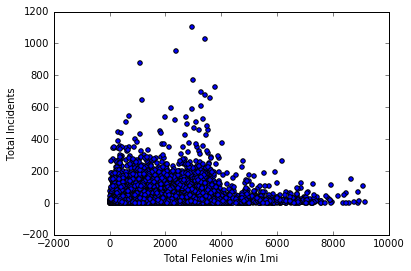

In [135]:
# womp.
school_df.plot(x='Total Felonies w/in 1mi',y='Total Incidents', kind='scatter')

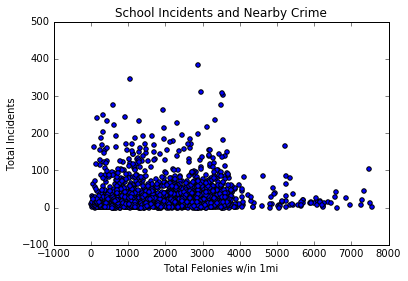

In [138]:
# trying again w/out school incident outliers and with only one point per school. double womp.
by_school = school_df.groupby('BEDS Code')['Total Incidents','Total Felonies w/in 1mi'].mean()
by_school[by_school['Total Incidents'] < 400].plot(x='Total Felonies w/in 1mi',y='Total Incidents', kind='scatter')
plt.title('School Incidents and Nearby Crime')

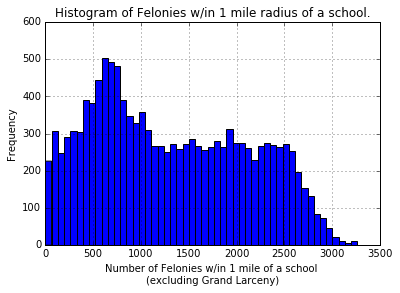

In [136]:
# histogram of non_larceny felonies within 1 mile of each school
school_df[NON_LARCENY_COLS].apply(sum,axis=1).hist(bins=50)
plt.xlabel('Number of Felonies w/in 1 mile of a school \n(excluding Grand Larceny)')
plt.ylabel('Frequency')
plt.title('Histogram of Felonies w/in 1 mile radius of a school.')

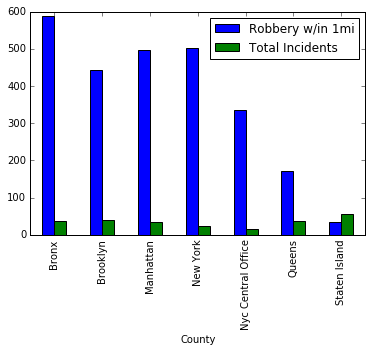

In [141]:
# the values differential makes it hard to say anything here, need to norm by pop
school_df.groupby('County')['Robbery w/in 1mi','Total Incidents'].mean().plot(kind='bar', legend=True)

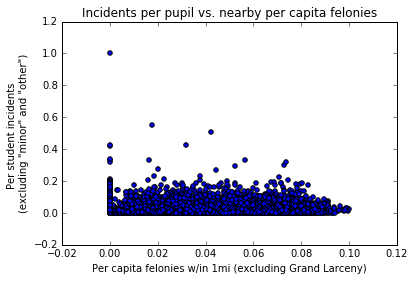

In [150]:
# Scatter plot of incidents per pupil (excluding outlying 'minor' and 'other' values) 
# vs nearby (non_larceny) crime adjusted by borough density

# x = per capita non larceny crime w/in a mile (adjusted using borough density)
pop_density = (borough_df['2010 Population']/borough_df['Area(sq mi)']).to_dict()
pop_density = {k.title(): pop_density[k] for k in pop_density.keys()}
xname = 'Per capita felonies w/in 1mi (excluding Grand Larceny)'
school_df[xname] = school_df[NON_LARCENY_COLS].sum(axis=1) / school_df.County.map(pop_density)

# y = non'other' and 'minor' VADIR incidents adjusted for school pop
NON_OTHER_INCIDENT_CAT = ['Assault','Bomb Threat, Riot, Arson','Sex Offenses, Kidnpping, Homicide',
                          'Burglary, Robbery, Theft', 'Criminal Mischief, Reckless Endangerment',
                          'Bullying','Alcohol or Drug Possession', 'Weapon Possession']
yname = 'Per student incidents \n(excluding "minor" and "other")'
school_df[yname] = school_df[NON_OTHER_INCIDENT_CAT].sum(axis=1) / school_df.Enrollment

school_df.plot(x=xname, y=yname, kind='scatter', title='Incidents per pupil vs. nearby per capita felonies')

In [ ]:
# Create bins by Local Felonies and plot average number of school incidents for each bin

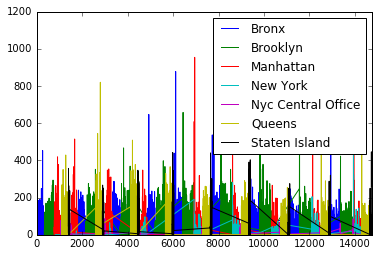

In [137]:
# I'm actually not at all sure what this is but its beautiful and very skyline reminiscent.
# boxplot of School Incidents by borough?
school_df.groupby('County')['Total Incidents'].plot(kind='box')
plt.legend()

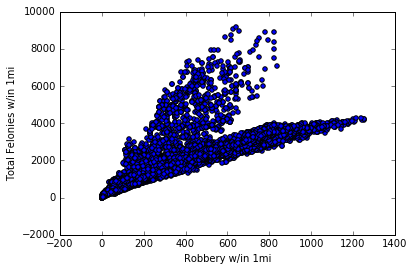

In [142]:
# this plot doesn't mean anything to us but I love the way it looks
school_df.plot(x='Robbery w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')